### Ideas
1. Binning
2. Make sizes equal in a random batch (will need the network to be independent of image size)
3. Use aspect ratio to resize. Binning on aspect ratio and then resize in the network.

In [1]:
## Imports
import os
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
## Global variables
train_json = 'train.json'
train_path = 'train/'

In [3]:
train_inp = open(train_json).read()
train_inp = json.loads(train_inp)
df = pd.DataFrame(train_inp['annotations'])

# Binarize the labels
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('labelId')),
                          columns=mlb.classes_,
                          index=df.index))

In [4]:
df.columns

Index(['imageId', '1', '10', '100', '101', '102', '103', '104', '105', '106',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=229)

In [5]:
# Load image sizes
files = os.listdir(train_path)
size = dict()

for file in files:
    img = Image.open(os.path.join(train_path, file))
    size[file.split('.jpg')[0]] = img.size
    
df_size = pd.DataFrame(list(size.values()), index=list(map(int, size.keys())), columns=['x', 'y'])

In [6]:
df_final = pd.concat([df.iloc[df_size.index], df_size], axis=1)

In [7]:
df_final[:5]

,imageId,1,10,100,101,102,103,104,105,106,...,92,93,94,95,96,97,98,99,x,y
156054,156055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,600,600
110285,110286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,507,600
286607,286608,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,600,600
482820,482821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,600,600
194734,194735,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,388,500


In [11]:
# del df; del df_size
import gc; gc.collect()

150

## Correlation of image size with labels

In [12]:
correlation = df_final.drop('imageId', axis=1).corr()

In [13]:
correlation[correlation==1] = 0

In [14]:
correlation.max()[correlation.max() == correlation.max().max()]

151    0.76811
59     0.76811
dtype: float64

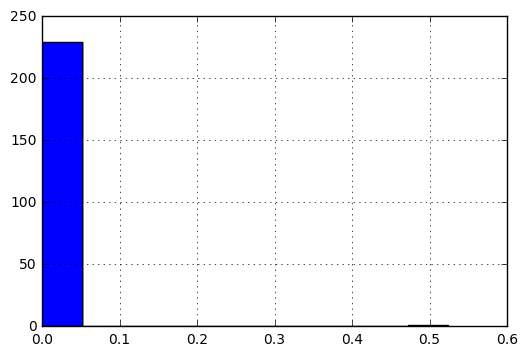

In [15]:
correlation['x'].abs().hist()

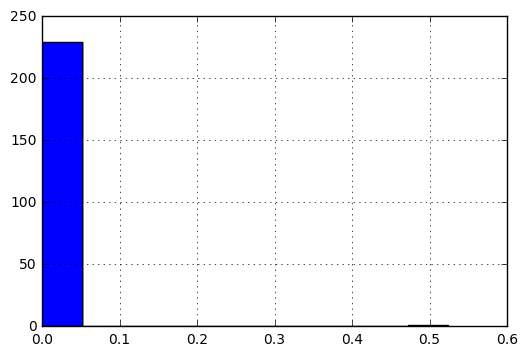

In [16]:
correlation['x'].abs().hist()

In [17]:
df_final['aspect'] = df_final.x / df_final.y

In [18]:
corr_aspect = df_final.corr()

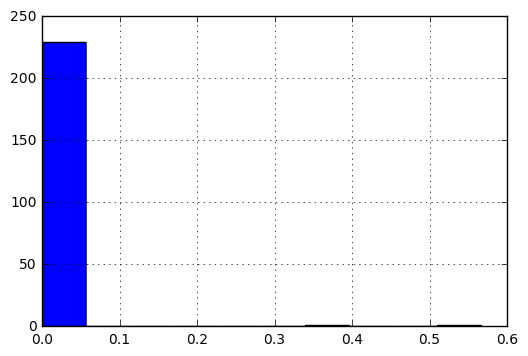

In [19]:
corr_aspect[corr_aspect == 1] = 0
np.abs(corr_aspect['aspect']).hist()

In [20]:
corr_aspect['aspect'][corr_aspect['aspect'] == np.abs(corr_aspect['aspect'].max())]

x    0.565927
Name: aspect, dtype: float64

In [21]:
corr_aspect['aspect']['y']

-0.36655904979813431

## Result: No correlation between labels and image size or aspect ratio.

In [22]:
df_final.to_csv('df.csv')

# Batch generators

In [3]:
# If img_size given spits out batches of that file size. If not given randomly selects and resizes images. If a_ratio
# given spits out images for that aspect ratio after resizing.

def compute_df(train_json, train_path, max_size=None):
    if 'df_final.csv' in os.listdir('.'):
        return pd.read_csv('df_final.csv')
    
    train_inp = open(train_json).read()
    train_inp = json.loads(train_inp)
    df = pd.DataFrame(train_inp['annotations'])
    df.imageId = df.imageId.astype('int')
    df.index = df.imageId
    df.drop('imageId', axis=1, inplace=True)

    # Binarize the labels
    mlb = MultiLabelBinarizer()
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('labelId')),
                              columns=mlb.classes_,
                              index=df.index))
    
    # Compute image sizes
    files = os.listdir(train_path)
    if max_size:
        files = files[:10000]
    size = dict()

    for file in files:
        try:
            img = Image.open(os.path.join(train_path, file))
        except OSError:
            print("Couldn't load file: ", file)
        size[file.split('.jpg')[0]] = img.size

    df_size = pd.DataFrame(list(size.values()), index=list(map(int, size.keys())), columns=['x', 'y'])
    
    # Join all results
    df_final = pd.concat([df.loc[df_size.index], df_size], axis=1)
    df_final['aspect_ratio'] = df_final.x / df_final.y
    
    # Write the results to file
    df_final.to_csv('df_final.csv')
    del df; del df_size
    return df_final

In [32]:
class BatchGenerator:
    def __init__(self, train_json, train_path, df=None, size=None, a_ratio=None, resample=Image.LANCZOS,
                 batch_size=32, n_jobs=-1):
        """
        Initializer for Batch generator.
        
        Parameters
        ----------
        train_json: str
            path to the training dataset json file
        
        train_path: str
            path to the dir containing all the image files
        
        df: str (optional)
            path to the csv file containing the image ids, labels, image sizes,
            and aspect ratio. If None, calls compute_df to generate the file.
        
        size: list, type: [(x_size, y_size), ...] (optional)
            If specified, randomly selects a pair of x_size and y_size from `size`
            and generates a batch with images of size (x_size \pm 50, y_size \pm 50).
            If None, randomly selects images and resizes them to (299, 299).
        
        a_ratio: list (optional)
            Randomly selects the aspect ratio from `a_ratio` and generates a batch of
            images of (299, 299) using images within aspect ratio of \pm 0.25.
            If None, falls back to argument size=None.
        
        resample: PIL Resampling methods
            The resampling method to resize the images.
        
        batch_size: int
            The number of images returned in each batch.
            
        n_jobs: int (or -1)
            Number of workers to use. If -1, uses maximum number of workers.
            
        Returns
        -------
        X: array
            Array of images of size `batch_size`
        
        y: array
            Array of binarized labels of size `batch_size`.
        """
        self.train_json = train_json
        self.train_path = train_path
        self.df = pd.read_csv(df) if df else compute_df(self.train_)
        
        if size is not None and a_ratio is not None:
            raise ValueError("Only one of size and a_ratio can be specified")
        self.size = size
        self.a_ratio = a_ratio
        self.batch_size = batch_size
        self.n_batches = self.df.shape[0] // self.batch_size
        self.n_jobs = n_jobs
    
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def resize(self, img_id, image_size, resample=Image.LANCZOS, resize=False):
        """
        Resizes the image to specified size.
        """
        try:
            img = Image.open(os.path.join(self.train_path, str(img_id) + '.jpg'))
        except OSError:
            print("Couldn't load image: ", str(img_id)+'.jpg')
        
        
        return np.array(img.resize(image_size, resample=resample))
    
    def create_batch(self, df, resize=False, image_size=(299, 299), n_jobs=-1):
        """
        Creates a batch from given df by loading the image files.
        
        Parameters
        ----------
        df: DataFrame object
        """
        image_ids = df.index
        y = df.drop(['x', 'y', 'aspect_ratio'], axis=1).values
        
        # Load images and resize them
        X = Parallel(n_jobs=n_jobs)(delayed(self.resize)(img_id, image_size) for img_id in image_ids)
#         X = [self.resize(img_id, image_size) for img_id in image_ids]
        return np.array(X), y
    
    def next(self):
        if self.a_ratio:
            while True:
                aspect_ratio = np.random.choice(self.a_ratio)
                df_select = self.df[(self.df.aspect_ratio > (aspect_ratio - 0.25)) & 
                                    (self.df.aspect_ratio < (aspect_ratio + 0.25))].sample(self.batch_size,
                                                                                           replace=True)
                X_batch, y_batch = self.create_batch(df_select, resize=True,
                                                     image_size=(299, 299), n_jobs=self.n_jobs)
                return (X_batch, y_batch)
        elif self.size:
            while True:
                size = self.size[np.random.randint(len(self.size))]
                df_select = self.df[
                    (self.df.x > (size[0] - 50)) & (self.df.x < (size[1] + 50)) &
                    (self.df.y > (size[1] - 50)) & (self.df.y < (size[1] + 50))].sample(self.batch_size,
                                                                                        replace=True)
                X_batch, y_batch = self.create_batch(df_select, resize=True,
                                                     image_size=size, n_jobs=self.n_jobs)
                return (X_batch, y_batch)
        else:
            while True:
                df_select = self.df.sample(self.batch_size, replace=True)
                X_batch, y_batch = self.create_batch(df_select, resize=True,
                                                     image_size=(299, 299), n_jobs=self.n_jobs)
                return (X_batch, y_batch)

In [33]:
import gc; gc.collect()

323

In [35]:
batch_gen_apect = BatchGenerator(train_json='train.json', train_path='train/', df='df_final.csv',
                                 size=None, a_ratio=[1.0], batch_size=32, n_jobs=-1)
batch_gen_multiaspect = BatchGenerator(train_json='train.json', train_path='train/', df='df_final.csv',
                                       size=None, a_ratio=[1.0, 2.0], batch_size=32, n_jobs=-1)

batch_get_fixed_sizes = BatchGenerator(train_json='train.json', train_path='train/', df='df_final.csv',
                                       size=[(400, 400), (500, 500), (600, 600)], a_ratio=None,
                                       batch_size=32, n_jobs=-1)
batch_get_standard = BatchGenerator(train_json='train.json', train_path='train/', df='df_final.csv',
                                       size=None, a_ratio=None, batch_size=32, n_jobs=-1)


i = 0
for batch_x, batch_y in batch_get_standard:
    print(batch_x.shape)
    print(batch_y.shape)
    i+=1
    if i > 50:
        break

(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
(32, 299, 299, 3)
(32, 229)
Couldn't load image:  0.jpg


JoblibUnboundLocalError: JoblibUnboundLocalError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.4/site-packages/ipykernel/__main__.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/runpy.py in _run_code(code=<code object <module> at 0x7f479cb49390, file "/...3.4/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ankur/miniconda3/envs/mlip/lib/python3.4/s...ges/ipykernel/__pycache__/__main__.cpython-34.pyc', '__doc__': None, '__file__': '/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.4/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ankur/.../python3.4/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.4/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f479cb49390, file "/...3.4/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ankur/miniconda3/envs/mlip/lib/python3.4/s...ges/ipykernel/__pycache__/__main__.cpython-34.pyc', '__doc__': None, '__file__': '/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.4/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ankur/.../python3.4/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-05-07T07:34:50.516817', 'msg_id': '324D584A540A47AC9A3B0CB781DDD105', 'msg_type': 'execute_request', 'session': '39619039120840C289A97A6AE4186CF3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '324D584A540A47AC9A3B0CB781DDD105', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'39619039120840C289A97A6AE4186CF3']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-05-07T07:34:50.516817', 'msg_id': '324D584A540A47AC9A3B0CB781DDD105', 'msg_type': 'execute_request', 'session': '39619039120840C289A97A6AE4186CF3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '324D584A540A47AC9A3B0CB781DDD105', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'39619039120840C289A97A6AE4186CF3'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-05-07T07:34:50.516817', 'msg_id': '324D584A540A47AC9A3B0CB781DDD105', 'msg_type': 'execute_request', 'session': '39619039120840C289A97A6AE4186CF3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '324D584A540A47AC9A3B0CB781DDD105', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="batch_gen_apect = BatchGenerator(train_json='tra...ch_y.shape)\n    i+=1\n    if i > 50:\n        break", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-35-dbfa9a551eac>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f47726c2d68, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f4762a70db0, file "<ipython-input-35-dbfa9a551eac>", line 14>
        result = <ExecutionResult object at 7f47726c2d68, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f4762a70db0, file "<ipython-input-35-dbfa9a551eac>", line 14>, result=<ExecutionResult object at 7f47726c2d68, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f4762a70db0, file "<ipython-input-35-dbfa9a551eac>", line 14>
        self.user_global_ns = {'BatchGenerator': <class '__main__.BatchGenerator'>, 'Image': <module 'PIL.Image' from '/home/ankur/miniconda3...s/mlip/lib/python3.4/site-packages/PIL/Image.py'>, 'In': ['', "## Imports\nimport os\nimport json\nfrom collection...delayed\n\nget_ipython().magic('matplotlib inline')", "## Global variables\ntrain_json = 'train.json'\ntrain_path = 'train/'", 'class BatchGenerator:\n    def __init__(self, tra....n_jobs)\n                yield (X_batch, y_batch)', 'class BatchGenerator:\n    def __init__(self, tra....n_jobs)\n                yield (X_batch, y_batch)', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", 'class BatchGenerator:\n    def __init__(self, tra....n_jobs)\n                yield (X_batch, y_batch)', 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", "batch_gen = BatchGenerator(train_json='train.jso...batch_x.shape)\n    print(batch_y.shape)\n    break", 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', ...], 'MultiLabelBinarizer': <class 'sklearn.preprocessing.label.MultiLabelBinarizer'>, 'Out': {8: 82, 12: 175, 15: 145, 19: 342, 23: 196, 29: 439, 33: 323}, 'PIL': <module 'PIL' from '/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/PIL/__init__.py'>, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': 323, '_12': 175, '_15': 145, ...}
        self.user_ns = {'BatchGenerator': <class '__main__.BatchGenerator'>, 'Image': <module 'PIL.Image' from '/home/ankur/miniconda3...s/mlip/lib/python3.4/site-packages/PIL/Image.py'>, 'In': ['', "## Imports\nimport os\nimport json\nfrom collection...delayed\n\nget_ipython().magic('matplotlib inline')", "## Global variables\ntrain_json = 'train.json'\ntrain_path = 'train/'", 'class BatchGenerator:\n    def __init__(self, tra....n_jobs)\n                yield (X_batch, y_batch)', 'class BatchGenerator:\n    def __init__(self, tra....n_jobs)\n                yield (X_batch, y_batch)', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", 'class BatchGenerator:\n    def __init__(self, tra....n_jobs)\n                yield (X_batch, y_batch)', 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', "batch_gen = BatchGenerator(train_json='train.jso... batch_gen.__iter__()\n    print(X.shape, y.shape)", "batch_gen = BatchGenerator(train_json='train.jso...batch_x.shape)\n    print(batch_y.shape)\n    break", 'class BatchGenerator:\n    def __init__(self, tra...n_jobs)\n                return (X_batch, y_batch)', 'import gc; gc.collect()', ...], 'MultiLabelBinarizer': <class 'sklearn.preprocessing.label.MultiLabelBinarizer'>, 'Out': {8: 82, 12: 175, 15: 145, 19: 342, 23: 196, 29: 439, 33: 323}, 'PIL': <module 'PIL' from '/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/PIL/__init__.py'>, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': 323, '_12': 175, '_15': 145, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/ankur/kaggle/fashion/<ipython-input-35-dbfa9a551eac> in <module>()
      9 batch_get_standard = BatchGenerator(train_json='train.json', train_path='train/', df='df_final.csv',
     10                                        size=None, a_ratio=None, batch_size=32, n_jobs=-1)
     11 
     12 
     13 i = 0
---> 14 for batch_x, batch_y in batch_get_standard:
     15     print(batch_x.shape)
     16     print(batch_y.shape)
     17     i+=1
     18     if i > 50:

...........................................................................
/home/ankur/kaggle/fashion/<ipython-input-32-5b9cd6b2d539> in __next__(self=<__main__.BatchGenerator object>)
     57     
     58     def __iter__(self):
     59         return self
     60 
     61     def __next__(self):
---> 62         return self.next()
     63 
     64     def __len__(self):
     65         # Provide length in number of batches
     66         return self.n_batches

...........................................................................
/home/ankur/kaggle/fashion/<ipython-input-32-5b9cd6b2d539> in next(self=<__main__.BatchGenerator object>)
    114                 return (X_batch, y_batch)
    115         else:
    116             while True:
    117                 df_select = self.df.sample(self.batch_size, replace=True)
    118                 X_batch, y_batch = self.create_batch(df_select, resize=True,
--> 119                                                      image_size=(299, 299), n_jobs=self.n_jobs)
    120                 return (X_batch, y_batch)
    121 
    122 
    123 

...........................................................................
/home/ankur/kaggle/fashion/<ipython-input-32-5b9cd6b2d539> in create_batch(self=<__main__.BatchGenerator object>, df=      Unnamed: 0  1  10  100  101  102  103  104...600  600      1.000000  

[32 rows x 232 columns], resize=True, image_size=(299, 299), n_jobs=-1)
     86         """
     87         image_ids = df.index
     88         y = df.drop(['x', 'y', 'aspect_ratio'], axis=1).values
     89         
     90         # Load images and resize them
---> 91         X = Parallel(n_jobs=n_jobs)(delayed(self.resize)(img_id, image_size) for img_id in image_ids)
     92 #         X = [self.resize(img_id, image_size) for img_id in image_ids]
     93         return np.array(X), y
     94     
     95     def next(self):

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
UnboundLocalError                                  Mon May  7 07:35:26 2018
PID: 12063        Python 3.4.5: /home/ankur/miniconda3/envs/mlip/bin/python
...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<bound method BatchGenerator.resize of <__main__.BatchGenerator object>>, (5664, (299, 299)), {}), (<bound method BatchGenerator.resize of <__main__.BatchGenerator object>>, (0, (299, 299)), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <bound method BatchGenerator.resize of <__main__.BatchGenerator object>>
        args = (0, (299, 299))
        kwargs = {}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/ankur/kaggle/fashion/<ipython-input-32-5b9cd6b2d539> in resize(self=<__main__.BatchGenerator object>, img_id=0, image_size=(299, 299), resample=1)
     72         try:
     73             img = Image.open(os.path.join(self.train_path, str(img_id) + '.jpg'))
     74         except OSError:
     75             print("Couldn't load image: ", str(img_id)+'.jpg')
     76         
---> 77         return np.array(img.resize(image_size, resample=resample))
     78     
     79     def create_batch(self, df, resize=False, image_size=(299, 299), n_jobs=-1):
     80         """
     81         Creates a batch from given df by loading the image files.

UnboundLocalError: local variable 'img' referenced before assignment
___________________________________________________________________________